## Prerequisits

In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import numpy as np
# from scipy.sparse import csr_matrix

# import warnings
# warnings.filterwarnings('ignore')

### LLM Response data

In [ ]:
# model_name = "llama-3.1-8b-it"
# model_name = "gemma-2-9b-it"

# Prompting
# votes = pd.read_csv(f"analysis/{model_name}_votes.csv")
# print(votes.isna().sum())
# response_cols = [col for col in votes.columns if col not in ['category', 'q_id']]
# votes = votes[response_cols].T

# Steering 
# votes_1 = pd.read_csv(f"analysis/{model_name}_conservative_steering_131K_votes.csv")
# print(votes_1.isna().sum())
# votes_2 = pd.read_csv(f"analysis/{model_name}_liberal_steering_131K_votes.csv")
# print(votes_2.isna().sum())
# response_cols = [col for col in votes_1.columns if col not in ['category', 'q_id']]
# votes_1 = votes_1[response_cols].rename(columns={col: f"-ve_{col[9:]}" for col in response_cols})
# votes_2 = votes_2[response_cols].rename(columns={col: f"+ve_{col[9:]}" for col in response_cols})
# votes = pd.concat([votes_1.T, votes_2.T])

# vote_matrix = votes.values
# member_info_df = pd.DataFrame({'idx': list(range(len(votes))),
#                    'bioname': votes.index,
#                    'party': ['U']*len(votes)})

# votes = pd.read_csv("Statements_Arguments_Base.csv", index_col=0)
votes = pd.read_csv("LLM_responses_close_ended.csv", index_col=0)

votes.rename(columns={'Llama-2-70b-chat-hf': 'Llama-2-70b-chat', 
                   'Llama-2-13b-chat-hf': 'Llama-2-13b-chat',
                   'OLMo-7B-0724-Instruct-hf': 'OLMo-7B-0724-Instruct', 
                   'Right-FT-Llama-3.1-8B-Instruct-DPO': 'Right-FT-Llama-3.1-8B-Instruct',
                   'Right-FT-Llama-2-7b-chat-hf-DPO': 'Right-FT-Llama-2-7b-chat', 
                   'Right-FT-Llama-2-13b-chat-hf-DPO': 'Right-FT-Llama-2-13b-chat'}, inplace=True)
columns = ['statement_abb', 'Llama-2-70b-chat', 'Llama-2-13b-chat',
       'OLMo-7B-0724-Instruct', 'Mistral-7B-Instruct-v0.3',
       'Llama-3.2-3B-Instruct', 'gemma-2-9b-it', 'Qwen2.5-3B-Instruct',
       'Qwen2.5-3B', 'DeepSeek-R1-Distill-Qwen-1.5B',
       'Right-FT-Llama-3.1-8B-Instruct', 'Right-FT-Llama-2-7b-chat',
       'Right-FT-Llama-2-13b-chat']
votes = votes[columns]
# belief_map = {"": 0, "true_left": 1, "pret_left": 0, "pret_right": 0, "true_right": 1}

belief_map = {
    "strongly_agree":1,
    "agree":1,
    "disagree":0,
    "strongly_disagree":0,
}


for c in votes.columns[1:]:
        votes[c] = votes[c].map(belief_map).astype(float)
# votes.T


member_info_df = pd.DataFrame({'idx': list(range(len(votes.columns[1:]))),
                   'bioname': votes.columns[1:],
                   'party': ['D']*len(votes.columns[1:9]) + ['R']*len(votes.columns[9:])})

vote_matrix = votes.values[:,1:].T.astype(float)
vote_matrix

NameError: name 'pd' is not defined

## Check inputs

In [16]:
# most liberal: +ve_sta_argument_none:7
# most conservative:-ve_caa_argument_none:0


print(vote_matrix.shape)
member_info_df

(12, 19)


,idx,bioname,party
0,0,Llama-2-70b-chat,D
1,1,Llama-2-13b-chat,D
2,2,OLMo-7B-0724-Instruct,D
3,3,Mistral-7B-Instruct-v0.3,D
4,4,Llama-3.2-3B-Instruct,D
5,5,gemma-2-9b-it,D
6,6,Qwen2.5-3B-Instruct,D
7,7,Qwen2.5-3B,D
8,8,DeepSeek-R1-Distill-Qwen-1.5B,R
9,9,Right-FT-Llama-3.1-8B-Instruct,R


In [17]:
n_dims=2

n_members, n_rollcalls = vote_matrix.shape

# Create masks for observed votes
observed_mask = ~np.isnan(vote_matrix)

# Convert to binary format for observed votes only
vote_obs = vote_matrix[observed_mask].astype(int)

# Get indices for observed votes
member_idx, rollcall_idx = np.where(observed_mask)


# Assign each rollcall to a dimension (random assignment)
np.random.seed(42)  # for reproducibility
rollcall_to_dim = np.random.randint(0, n_dims, size=n_rollcalls)

# Create dimension index for each observation
dimension_idx = rollcall_to_dim[rollcall_idx]

print(f"Fitting {n_dims}D ideal point model...")
print("n_members:", n_members)
print("n_rollcalls:", n_rollcalls)
print("n_observations:", len(vote_obs))
print("Rollcalls per dimension:", np.bincount(rollcall_to_dim))

Fitting 2D ideal point model...
n_members: 12
n_rollcalls: 19
n_observations: 228
Rollcalls per dimension: [12  7]


## IRT Using Stan
***

In [18]:
# Create Stan data dictionary
stan_data = {
    'J': n_members,
    'K': n_rollcalls, 
    'N': len(vote_obs),
    'D': n_dims,
    'jj': member_idx+1, # starting idx 1
    'kk': rollcall_idx+1, # starting idx 1
    'y': vote_obs,
    #-------------------------------- Fix extreme Legislators --------------------------------#
    # 'ref_j1': 3 + 1, # role_liberal_argument_liberal
    # 'ref_j2': 8 + 1, # role_conservative_argument_conservative
    # 'ref_j3': 7 + 1, # role_liberal_argument_conservative
    
    'ref_j1': 0 + 1, # +ve_sta_argument_liberal
    'ref_j2': 10 + 1, # -ve_sta_argument_conservative
    'ref_j3': 8 + 1, # -ve_sta_argument_liberal
    #-------------------------------- Fix extreme Legislators --------------------------------#
}

# import numpy as np

# # Choose 3 legislators to fix (you can pick based on domain knowledge)
# # For example, most liberal, most conservative, and someone in between
# fixed_legislators = [0, 1, 2]  # indices in your data (0-based)

# # Define their positions in 2D space
# # Common approach: place them at corners of a triangle
# fixed_positions = np.array([
#     [-1.0, -1.0],  # bottom-left
#     [ 1.0, -1.0],  # bottom-right  
#     [ 0.0,  1.0]   # top-center
# ])

# stan_data = {
#     'J': n_members,
#     'K': n_rollcalls, 
#     'N': len(vote_obs),
#     'D': n_dims,
#     'jj': member_idx+1,
#     'kk': rollcall_idx+1,
#     'y': vote_obs,
#     'n_fixed': 3,
#     'fixed_legs': [x+1 for x in fixed_legislators],  # convert to 1-based indexing
#     'fixed_pos': fixed_positions
# }
stan_data

{'J': 12,
 'K': 19,
 'N': 228,
 'D': 2,
 'jj': array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,
         7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,
         9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
         9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 12, 12, 12, 12

In [19]:
import arviz as az
from cmdstanpy import CmdStanModel

stan_file = os.path.join('./MIRT_ref.stan')
model = CmdStanModel(stan_file=stan_file)
# print(model)
# print(json.dumps(model.exe_info(), indent=4))

In [20]:
n_samples=500
n_tune=500

fit = model.sample(
    data=stan_data, chains=4, 
    iter_sampling=n_samples, 
    iter_warmup=n_tune,
    # show_console=True
)

09:46:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

09:46:30 - cmdstanpy - INFO - CmdStan done processing.
09:46:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'MIRT_ref.stan', line 80, column 4 to column 81)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'MIRT_ref.stan', line 80, column 4 to column 81)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'MIRT_ref.stan', line 80, column 4 to column 81)
	Exception: lkj_corr_lpdf: Correlation matrix is not positive definite. (in 'MIRT_ref.stan', line 64, column 2 to column 29)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'MIRT_ref.stan', line 80, column 4 to column 81)
	Exception: lkj_corr_lpdf: Correlation 

In [21]:
inference_data = az.from_cmdstanpy(fit)
inference_data
inference_data.to_netcdf(f"./inference_data_response.nc")

'./inference_data_response.nc'

### Diagnosis

In [ ]:
print(fit.diagnose())

In [ ]:
# import matplotlib.cm as cm

# n_chains = len(inference_data.posterior.chain)
# n_vars = len(inference_data.posterior.data_vars)
# print(f"Number of parameter variables: {n_vars}")

# # cmap = cm.get_cmap('ocean')  # or 'plasma', 'tab10', etc.
# # colors = [cmap(i / (n_chains - 1)) for i in range(n_chains)]

# az.plot_trace(inference_data, figsize=(20, 2*n_vars), legend=False) #chain_prop={'color': colors},
# plt.tight_layout()
# plt.show()

### IDEAL Points

In [22]:
"""
Extract mean ideal points from trace

IRT CONNECTION: These are the estimated person parameters (abilities/traits)
In educational IRT: student ability estimates
In political IRT: legislator ideological position estimates
"""
# inference_data = az.from_netcdf(f"analysis/inference_data{model_name}_steering.nc")

ideal_points_samples = inference_data.posterior['theta'].values
# Average across chains and samples to get point estimates
ideal_points = np.mean(ideal_points_samples, axis=(0, 1))

# Print some diagnostics
print(f"\nIdeal points shape: {ideal_points.shape}")
print("Ideal_points_sample:")
print(ideal_points[:5])
print(f"Dimension 1 range: [{ideal_points[:, 0].min():.3f}, {ideal_points[:, 0].max():.3f}]")
print(f"Dimension 2 range: [{ideal_points[:, 1].min():.3f}, {ideal_points[:, 1].max():.3f}]")



Ideal points shape: (12, 2)
Ideal_points_sample:
[[-2.         -0.0690483 ]
 [-1.04160475  1.45314452]
 [ 0.05711875 -0.51096223]
 [-0.42852892  0.11189645]
 [-0.41869129  0.33520851]]
Dimension 1 range: [-2.000, 2.000]
Dimension 2 range: [-1.501, 2.000]


### Check Correlations

### Plot IDEAL Points

In [23]:
cm_mapping = {
        'Llama-2-70b-chat':('o', '#2175b2'),
        'Llama-2-13b-chat':('^', '#2175b2'),
        'OLMo-7B-0724-Instruct':('s', '#2175b2'),
        'Mistral-7B-Instruct-v0.3':('p', '#2175b2'),
        'Llama-3.2-3B-Instruct':('P', '#2175b2'),
        'gemma-2-9b-it':('v', '#2175b2'),
        'Qwen2.5-3B-Instruct':('*', '#2175b2'),
        'Qwen2.5-3B':('<', '#2175b2'),
        'DeepSeek-R1-Distill-Qwen-1.5B':('>', '#a82d30'),
        'Right-FT-Llama-3.1-8B-Instruct':('X', '#a82d30'),
        'Right-FT-Llama-2-7b-chat':('d', '#a82d30'),
        'Right-FT-Llama-2-13b-chat':('h', '#a82d30') 
        }


# cm_mapping = { "":('o', '#2175b2'), 
#                "":('^', '#2175b2'), 
#                "":('s', '#2175b2'), 
#                "":('p', '#2175b2'), 
#                "":('P', '#2175b2'), 
#                "":('v', '#2175b2'), 
#                "":('*', '#2175b2'), 
#                "":('<', '#2175b2'), 
#                "":('>', '#a82d30'), 
#                "":('X', '#a82d30'), 
#                "":('d', '#a82d30'), 
#                "":('h', '#a82d30')}


Creating plot...
Saving figure at ideal_points_llms_round_<built-in function round>.png


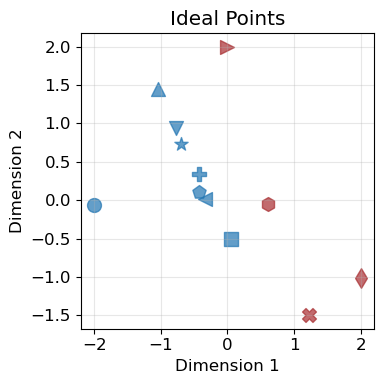

In [24]:
"""
Create the ideal points plot matching R output

IRT CONNECTION: This visualizes the estimated person parameters (θ) in 2D space
Each point represents a legislator's estimated ideological position
"""
print("Creating plot...")
plt.clf()
# Set up colors
party_colors = {'D': 'blue', 'R': 'red', 'I': 'green', 'U': 'purple'}
colors = [party_colors[party] for party in member_info_df['party']]

# Create plot
# plt.figure(figsize=(10, 10))
plt.rcParams.update({'font.size': 12, 'figure.figsize': (4,4)})

for i, (k, v) in enumerate(cm_mapping.items()):
    plt.scatter(ideal_points[i, 0], ideal_points[i, 1], 
                c=v[1], marker=v[0], s=100, alpha=0.7)

# Scatter plot of ideal points (IRT person parameters)
# plt.scatter(ideal_points[:, 0], ideal_points[:, 1], 
#             c=colors, s=50, alpha=0.7)

# Add labels for each point
# for i, row in member_info_df.iterrows():
#     # Format name like R output: "LASTNAME (PARTY STATE)"
#     name_parts = row['bioname'].split(', ')
#     if len(name_parts) >= 2:
#         lastname = name_parts[0]
#     else:
#         lastname = row['bioname']
    
#     # label = f"{lastname} ({row['party']} {row['state_abbrev']})"
#     # label = f"{lastname} ({row['party']})"
#     label = row['bioname']
    
#     plt.annotate(label, 
#                 (ideal_points[i, 0], ideal_points[i, 1]),
#                 xytext=(5, 5), textcoords='offset points',
#                 fontsize=12, alpha=0.8, rotation=-5, 
#                 ha='left', va='center', rotation_mode='anchor')

# Formatting
plt.xlabel('Dimension 1')  # First IRT dimension (usually liberal-conservative)
plt.ylabel('Dimension 2')  # Second IRT dimension
plt.title(f'Ideal Points')

# Legend
# legend_elements = [
#     plt.scatter([], [], c='blue', s=50, label='Democrat'),
#     plt.scatter([], [], c='red', s=50, label='Republican'),
#     plt.scatter([], [], c='green', s=50, label='Independent'),
#     # plt.scatter([], [], c='purple', s=100, label='LLM')
# ]
legend_elements = [plt.scatter([], [], marker=v[0], c=v[1], label=k) for k, v in cm_mapping.items()]

plt.grid(True, alpha=0.3)
plt.tight_layout()
print(f"Saving figure at ideal_points_llms_round_{round}.png")
plt.savefig(f"ideal_points_response.pdf")
plt.show()


### Summary

In [ ]:
print("\nSummary by party:")
for party in ['D', 'R', 'I', 'U']:
    party_mask = member_info_df['party'] == party
    if party_mask.any():
        party_points = ideal_points[party_mask]
        print(f"{party}: n={np.sum(party_mask)}, "
                f"Dim1 mean={np.mean(party_points[:, 0]):.3f}, "
                f"Dim2 mean={np.mean(party_points[:, 1]):.3f}")

print("\nIRT-based ideal point analysis complete!")